# Diabetes Prediction (BRFSS2015) + Bootstrap Evaluation

This notebook expects the CSV file **already in Colab** at:

`/diabetes_012_health_indicators_BRFSS2015.csv`

It trains a Logistic Regression classifier and evaluates accuracy using **bootstrap resampling**.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (8, 5)

file_path = "/content/dataset.csv"
df = pd.read_csv(file_path)

print("Dataset Loaded Successfully!")
print("Shape:", df.shape)
df.head()

Dataset Loaded Successfully!
Shape: (245670, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [18]:
print("Columns:")
print(df.columns.tolist())

print("\nOriginal target distribution (Diabetes_012):")
print(df["Diabetes_012"].value_counts())

Columns:
['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Original target distribution (Diabetes_012):
Diabetes_012
0.0    207222
2.0     34006
1.0      4442
Name: count, dtype: int64


In [19]:
# Binary target: 0 = no diabetes, 1 = prediabetes/diabetes
df["Diabetes_binary"] = df["Diabetes_012"].apply(lambda x: 0 if x == 0 else 1)

X = df.drop(columns=["Diabetes_012", "Diabetes_binary"])
y = df["Diabetes_binary"]

print("\nBinary class distribution:")
print(y.value_counts())
print("\nBinary class proportions:")
print(y.value_counts(normalize=True))


Binary class distribution:
Diabetes_binary
0    207222
1     38448
Name: count, dtype: int64

Binary class proportions:
Diabetes_binary
0    0.843497
1    0.156503
Name: proportion, dtype: float64


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (196536, 21)
Test shape: (49134, 21)


In [21]:
clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

baseline_acc = accuracy_score(y_test, y_pred)
print(f"\nBaseline Accuracy: {baseline_acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


Baseline Accuracy: 0.8496

Classification Report:
              precision    recall  f1-score   support

           0     0.8667    0.9711    0.9159     41444
           1     0.5558    0.1949    0.2886      7690

    accuracy                         0.8496     49134
   macro avg     0.7112    0.5830    0.6023     49134
weighted avg     0.8180    0.8496    0.8177     49134



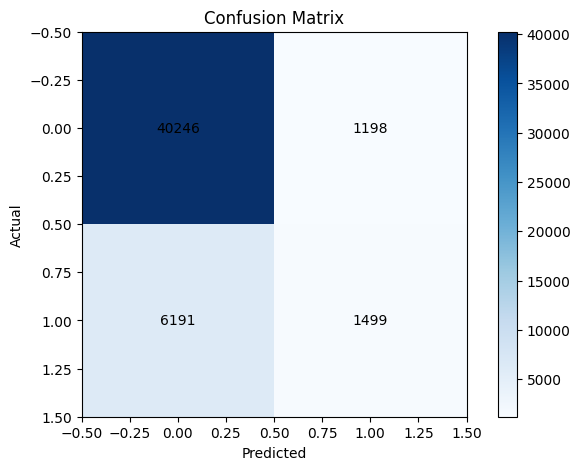

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.show()

In [28]:
# Bootstrap evaluation
n_bootstraps = 50  # change as desired
rng = np.random.default_rng(42)

boot_acc = []

for _ in range(n_bootstraps):
    idx = rng.integers(0, len(X_train), len(X_train))
    Xb = X_train.iloc[idx]
    yb = y_train.iloc[idx]

    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000))
    ])

    model.fit(Xb, yb)
    pred = model.predict(X_test)
    boot_acc.append(accuracy_score(y_test, pred))

boot_acc = np.array(boot_acc)

print("Bootstrap samples:", n_bootstraps)
print("Mean Bootstrap Accuracy:", boot_acc.mean())
print("Std Dev:", boot_acc.std())

lower, upper = np.percentile(boot_acc, [2.5, 97.5])
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

Bootstrap samples: 50
Mean Bootstrap Accuracy: 0.8495107257703424
Std Dev: 0.00021585211309257398
95% Confidence Interval: [0.8491, 0.8499]


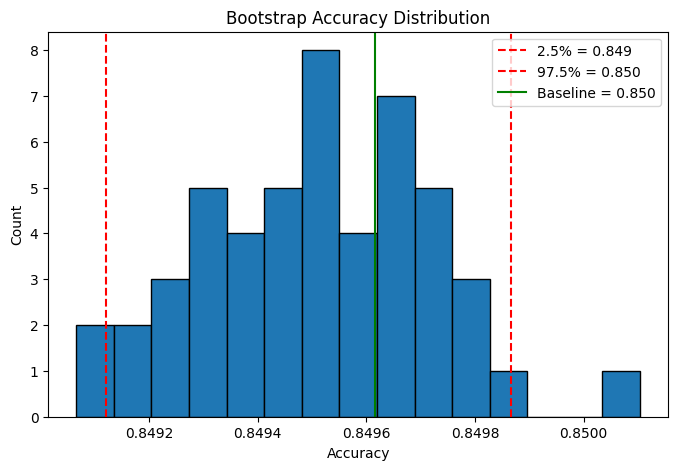

In [29]:
plt.hist(boot_acc, bins=15, edgecolor="black")
plt.axvline(lower, color="red", linestyle="--", label=f"2.5% = {lower:.3f}")
plt.axvline(upper, color="red", linestyle="--", label=f"97.5% = {upper:.3f}")
plt.axvline(baseline_acc, color="green", label=f"Baseline = {baseline_acc:.3f}")

plt.title("Bootstrap Accuracy Distribution")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.legend()
plt.show()